# RESOLVE01 学習データの生成・DNNモデルの構築
松本(2020)が再現できる範囲

In [1]:
%pwd # ~/ch01_generate_datasetsならOK

'/Users/quetzal/GL/geophysics/Repos/DLXEMAir/environment/JupyterNB'

## 1.1 データ生成

- import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
from keras.models import load_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

sys.path.append('../../')
from dlxem import emexecutor as em
from dlxem import networks, forward

Using TensorFlow backend.


- settings

In [3]:

config = {
    'thicks' : [10. for i in range(10)],
    'res_range' : (1e-2, 1e4),
    'height_range' : (15, 75),
    'freqs' : [382, 1822, 7970, 35920, 130100],
    'span' : 7.86,
    'to_ppm' : True,
    'add_noise' : True,
    'noise_level' : [10, 10, 20, 40, 50],
    'random_mode' : 'smooth_mix',
    'ground_char' : 'r'
}
thicks = config['thicks']
freqs = config['freqs']
span = config['span']

size = 10000
parallel_num = 8

file_tag = '20210628bresolve_'

dataset_path = '../DB/dataset/'
dsetfile_name = dataset_path + file_tag+'{}_{}.csv'.format(size, config['random_mode'])

model_path = '../CORE/'
histfile_name = model_path + 'history/' + file_tag + 'history.csv'
nnetfile_name = model_path + 'network/' + file_tag + 'network.h5'
print(span)

7.86


- run

In [4]:
if os.path.exists(dsetfile_name):
    print('Datasets already exist')
else:
    resolve = em.Resolve1D(**config)
    data = resolve.multi_process(size, parallel_num)

    df = pd.DataFrame(data)
    df.to_csv(dsetfile_name, header=None, index=False)
    print("-> /" + dsetfile_name)

Datasets already exist


## 1.2 モデル学習

In [5]:
#全体読み込み
df = pd.read_csv(dsetfile_name, header=None)

#分割
x = df.iloc[:, :11].values
y = df.iloc[:, 11:].values
y = np.log10(y)
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.02, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=0)
x_test_org = x_test.copy()
#x正規化
sc = preprocessing.StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

In [6]:
if os.path.exists(nnetfile_name):
    print('The Specified Neural Network Model Already Exists.')
    network = load_model(nnetfile_name)
    hist_df = pd.read_csv(histfile_name)
else:
    input_dim = x.shape[1]
    output_dim = y.shape[1]
    network = networks.get_dnn(input_dim, output_dim)
    history = network.fit(x_train, y_train, batch_size=64, epochs=100, verbose=2, validation_data=(x_val, y_val))
    network.save(nnetfile_name)
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(histfile_name)

The Specified Neural Network Model Already Exists.



# 評価・テスト

## 学習過程

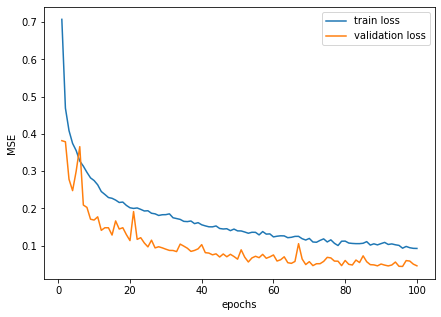

In [7]:
epochs = 100
epochs = np.arange(1, epochs+1)
val_mse = hist_df['val_loss'].values
loss = hist_df['loss'].values
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.plot(epochs, loss, label='train loss')
ax.plot(epochs, val_mse, label='validation loss')
ax.set_xlabel('epochs')
ax.set_ylabel('MSE')
ax.legend()

# MSE分布と累積度数

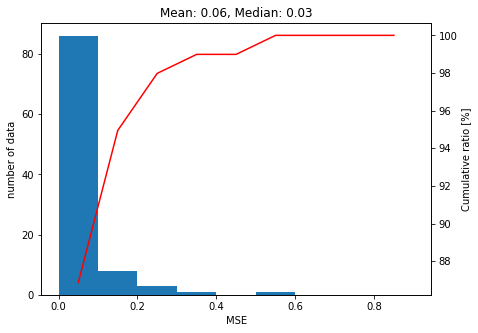

In [8]:
terr = (y_test - network.predict(x_test))**2
res_mse = np.array([k.mean() for k in terr])

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
bins = [.1*(i) for i in range(10)] #適宜調整
n, bins, patches = ax.hist(res_mse, bins=bins)
y2 = np.add.accumulate(n) / n.sum() * 100
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
ax.set_xlabel('MSE')
ax.set_ylabel('number of data')
mean = np.mean(res_mse)
median = np.median(res_mse)
ax.set_title('Mean: {mean:.2f}, Median: {median:.2f}'.format(mean=mean, median=median))

# 第2軸のプロット
bx = ax.twinx()
lines = bx.plot(x2, y2, ls='-', color='r', label='Cumulative ratio')
bx.set_ylabel('Cumulative ratio [%]')
print('')

# テスト

50


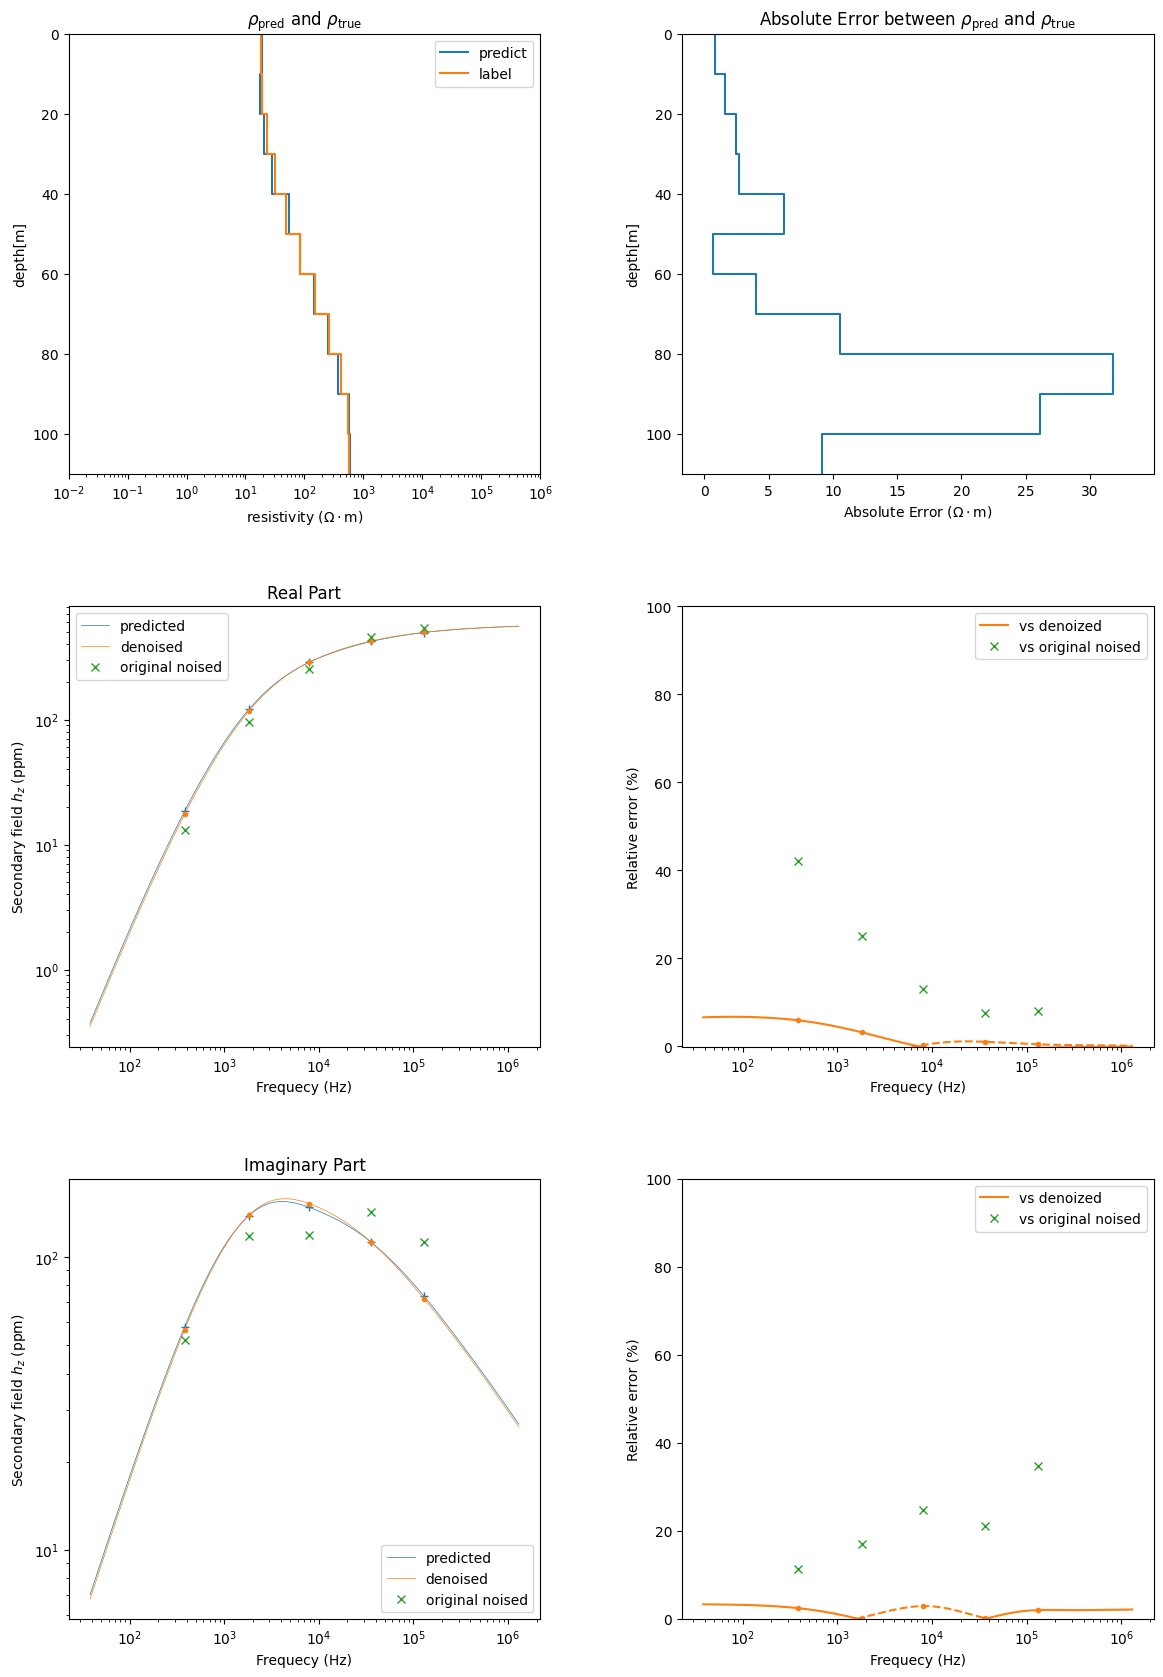

In [18]:
sys.path.append('../../')
from dlxem import myviz as viz

true_res = 10 ** y_test
pred_res = 10 ** network.predict(x_test)
orig_emf = x_test_org[:, :10]
height = x_test_org[:, 10]

test_data_size = len(y_test)
index = np.random.randint(0, test_data_size, 1)[0]

true_res = true_res[index]
pred_res = pred_res[index]
height = height[index]
orig_emf = orig_emf[index]

cfreq_size = 300
print(index)


fig = viz.resolve.sample_summary_plot(thicks, pred_res, true_res, height, span, freqs, cfreq_size, orig_emf)
fig.subplots_adjust(wspace=0.3, hspace=0.3)